# TimeSeries
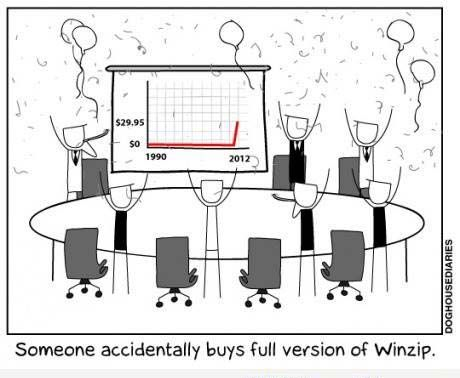

# Setup

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import xgboost as xgb

from statsmodels.tsa.filters.hp_filter import hpfilter

# Forecasting
* We're given 120 of the last days of sales
* We'd like to forecast daily sales over the next month
* We'll simulate this by creating & holding 30 observations privately 

# Data

## Generate Dataset

In [2]:
SIZE=150
HOLD=30

X_data = np.arange(SIZE)
y_data = X_data + (5 * np.random.randn(SIZE) + 5)

## Public - Private

In [3]:
X = X_data[:SIZE - HOLD]
y = y_data[:SIZE - HOLD]

X_private = X_data[SIZE - HOLD:]
y_private = y_data[SIZE - HOLD:]

In [4]:
X_private.shape

(30,)

## Plot

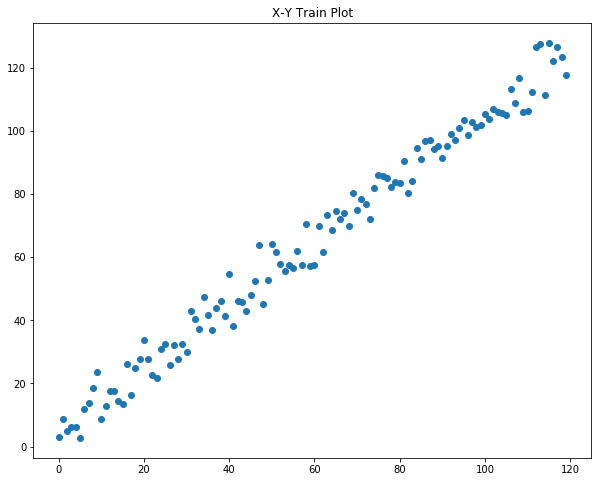

In [6]:
plt.figure(figsize=(10,8))
plt.scatter(X, y)
plt.title('X-Y Train Plot');

In [5]:
def score(y_hat, y_truth):
    mse = mean_squared_error(y_hat, y_truth)
    mae = mean_absolute_error(y_hat, y_truth)
    return (mse, mae)

def scorePrivate(y_hat):
    return score(y_hat, y_private)

# Random Train - Test Split

In [7]:
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X, y, test_size=0.25)

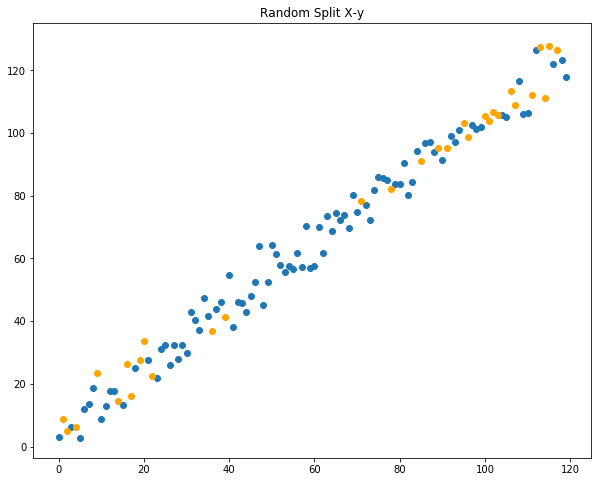

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(X_train_rand, y_train_rand)
plt.scatter(X_test_rand, y_test_rand, color='orange')
plt.title('Random Split X-y');

## Random Forest

In [9]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train_rand.reshape(-1,1),  y_train_rand)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Hold out Predictions

In [10]:
pred = rf.predict(X_test_rand.reshape(-1,1))
mse_rand, mae_rand = score(pred, y_test_rand)
print(f'MSE {mse_rand:.3f}  MAE {mae_rand:.3f}')

MSE 31.845  MAE 4.502


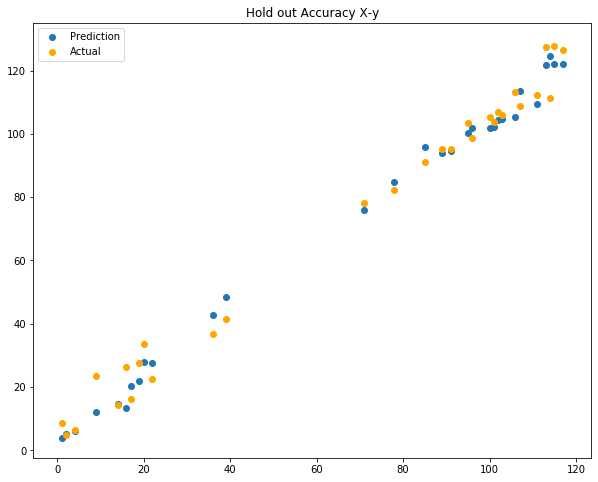

In [11]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_rand, pred, label='Prediction')
plt.scatter(X_test_rand, y_test_rand, color='orange', label='Actual')
plt.legend()
plt.title('Hold out Accuracy X-y');

## Deployed Predictions

In [12]:
pred = rf.predict(X_private.reshape(-1,1))
mse_rand_deployed, mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {mse_rand:.3f}  MAE {mae_rand:.3f}')
print(f'Deployed  : MSE {mse_rand_deployed:.3f}  MAE {mae_rand_deployed:.3f}')

Validation: MSE 31.845  MAE 4.502
Deployed  : MSE 450.105  MAE 19.344


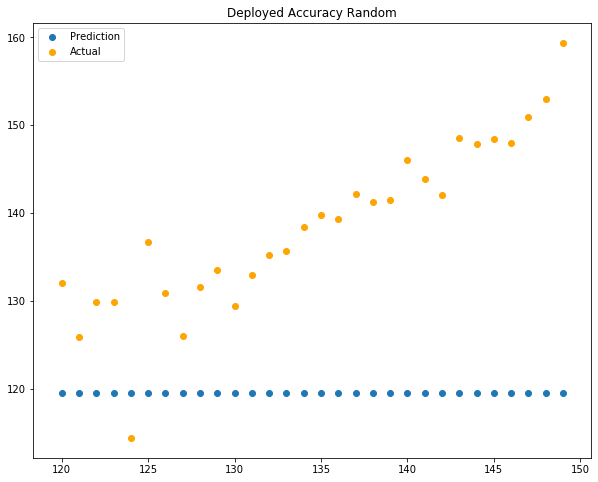

In [13]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('Deployed Accuracy Random');

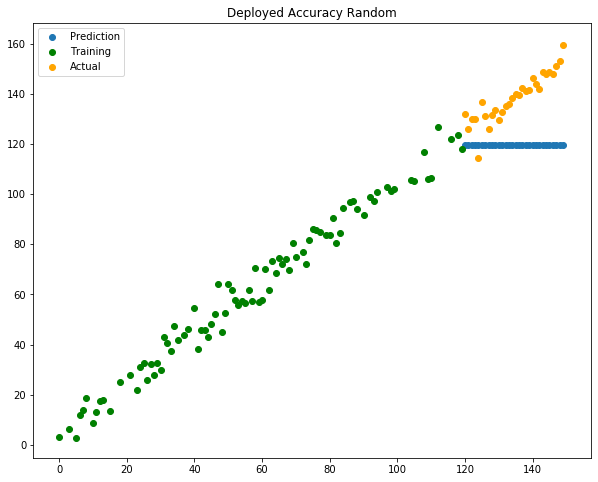

In [14]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('Deployed Accuracy Random');

## Conclusion
* Deployed model was a disaster
* We randomly sampled, and our validation results looked good
* Validation data didn't look like deployed data (some of it was older)
* Let's try again using the last n parts of the data

# Last "n" Observations

In [15]:
X_train_last = X[:90]; y_train_last = y[:90]
X_test_last  = X[90:]; y_test_last  = y[90:]

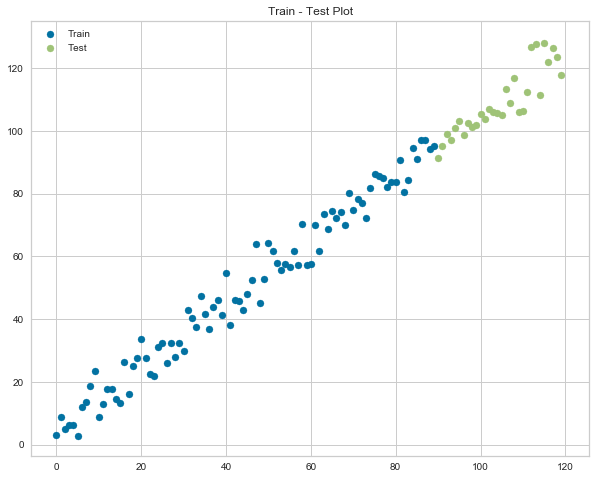

In [281]:
plt.figure(figsize=(10,8))
plt.scatter(X_train_last, y_train_last, label='Train')
plt.scatter(X_test_last, y_test_last, label='Test')
plt.legend()
plt.title('Train - Test Plot');

## Random Forest

In [283]:
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train_last.reshape(-1,1),  y_train_last)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## Hold Out Predictions

In [284]:
pred = rf.predict(X_test_last.reshape(-1,1))
mse_last, mae_last = score(pred, y_test_last)
print(f'Random Holdout  : MSE {mse_rand:.3f}  MAE {mae_rand:.3f}')
print(f'Random Deployed : MSE {mse_rand_deployed:.3f}  MAE {mae_rand_deployed:.3f}')
print(f'Last N Model    : MSE {mse_last:.3f}  MAE {mae_last:.3f}')

Random Holdout  : MSE 31.845  MAE 4.502
Random Deployed : MSE 450.105  MAE 19.344
Last N Model    : MSE 286.011  MAE 13.858


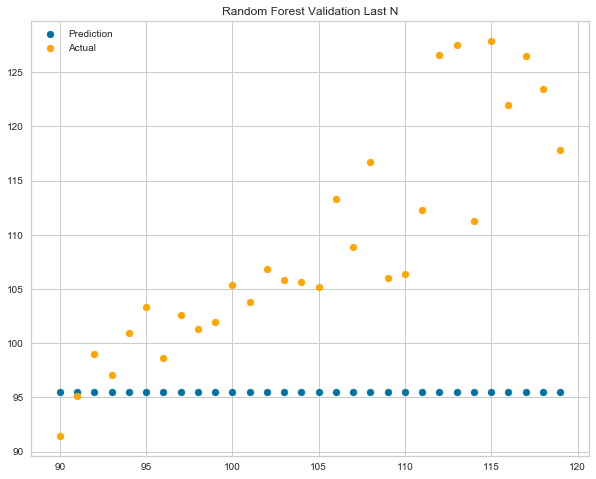

In [285]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_last, pred, label='Prediction')
plt.scatter(X_test_last, y_test_last, color='orange', label='Actual')
plt.legend()
plt.title('Random Forest Validation (Last N)');

## Deployed Predictions

In [286]:
pred = rf.predict(X_private.reshape(-1,1))
mse_last_deployed, mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {mse_last:.3f}  MAE {mae_last:.3f}')
print(f'Deployed  : MSE {mse_last_deployed:.3f}  MAE {mae_last_deployed:.3f}')

Validation: MSE 286.011  MAE 13.858
Deployed  : MSE 1940.102  MAE 43.025


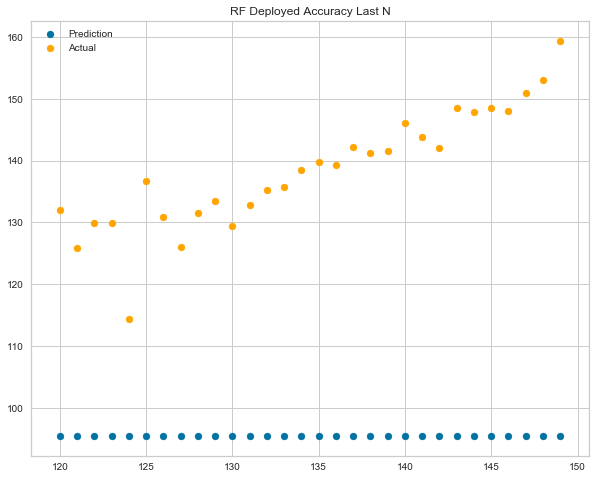

In [287]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('RF Deployed Accuracy (Last N');

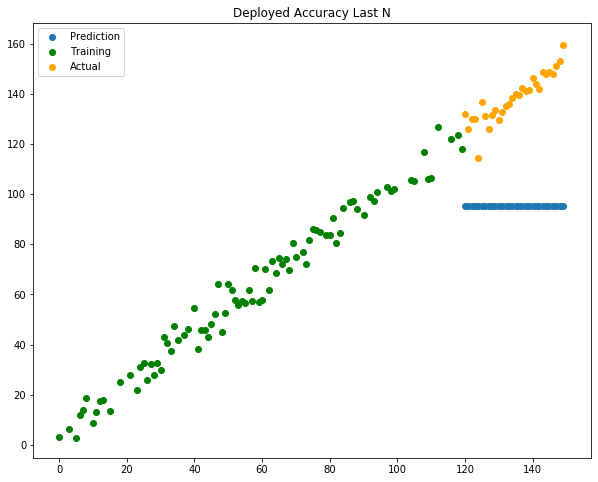

In [22]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('RF Deployed Accuracy (Last N)');

## Callout
* Our validation score was a much better indicator
* For date based dataets, a good strategy involves using last n validation
* Validation sets are everything - you want it to be as close to your target as possible
* Our problem was in the model choice - RandomForest
* A RandomForest can't model trend and forecasts outside of it's trained range
    * RandomForestRegressor predicts the mean of the observations in a leaf node
    * The RandomForest has large X values in a single leaf, and it uses that leaf for all predictions

# XGBoost

In [289]:
boost = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1)

## Random Train - Test Split

In [290]:
boost.fit(X_train_rand.reshape(-1,1),  y_train_rand)
pred = boost.predict(X_test_rand.reshape(-1,1))
xgb_mse_rand, xgb_mae_rand = score(pred, y_test_rand)
print(f'MSE {xgb_mse_rand:.3f}  MAE {xgb_mae_rand:.3f}')

MSE 37.351  MAE 4.917


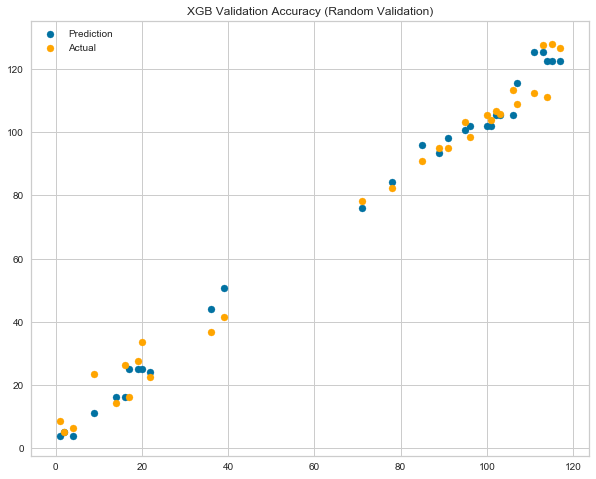

In [291]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_rand, pred, label='Prediction')
plt.scatter(X_test_rand, y_test_rand, color='orange', label='Actual')
plt.legend()
plt.title('XGB Validation Accuracy (Random Validation)');

In [261]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_mse_rand_deployed, xgb_mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_mse_rand:.3f}  MAE {xgb_mae_rand:.3f}')
print(f'Deployed  : MSE {xgb_mse_rand_deployed:.3f}  MAE {xgb_mae_rand_deployed:.3f}')
print(f'Validation MAE Error {(abs(xgb_mae_rand - xgb_mae_rand_deployed)) * 100.0 / xgb_mae_rand:.2f}%')

Validation: MSE 37.351  MAE 4.917
Deployed  : MSE 509.944  MAE 20.758
Validation MAE Error 322.13%


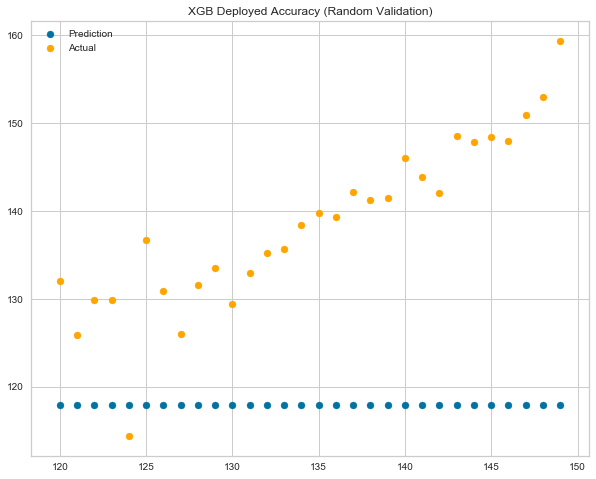

In [262]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('XGB Deployed Accuracy (Random Validation)');

## Last Train - Test Split

In [263]:
boost.fit(X_train_last.reshape(-1,1),  y_train_last)
pred = boost.predict(X_test_last.reshape(-1,1))
xgb_mse_last, xgb_mae_last = score(pred, y_test_last)
print(f'Random Holdout  : MSE {xgb_mse_rand:.3f}  MAE {xgb_mae_rand:.3f}')
print(f'Last N Model    : MSE {xgb_mse_last:.3f}  MAE {xgb_mae_last:.3f}')

Random Holdout  : MSE 37.351  MAE 4.917
Last N Model    : MSE 304.723  MAE 14.463


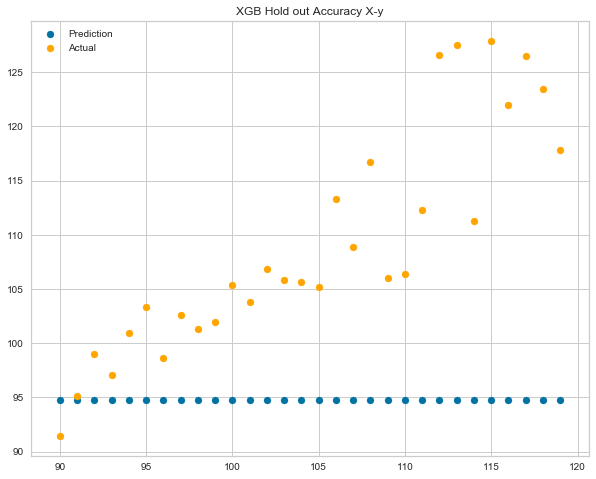

In [264]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_last, pred, label='Prediction')
plt.scatter(X_test_last, y_test_last, color='orange', label='Actual')
plt.legend()
plt.title('XGB Hold out Accuracy X-y');

In [265]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_mse_last_deployed, xgb_mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_mse_last:.3f}  MAE {xgb_mae_last:.3f}')
print(f'Deployed  : MSE {xgb_mse_last_deployed:.3f}  MAE {xgb_mae_last_deployed:.3f}')

Validation: MSE 304.723  MAE 14.463
Deployed  : MSE 1998.463  MAE 43.698


## Callout
* XGBoost with gbtree boosted learners can not capture a trend
* Last N hold out / validation set is helpful in catching this problem

# XGBoost - Linear Booster

In [266]:
boost = xgb.XGBRegressor(n_estimators=50, max_depth=2, learning_rate=0.3, booster='gblinear')

## Random Train - Test Split

In [267]:
boost.fit(X_train_rand.reshape(-1,1),  y_train_rand)
pred = boost.predict(X_test_rand.reshape(-1,1))
xgb_lin_mse_rand, xgb_lin_mae_rand = score(pred, y_test_rand)
print(f'MSE {xgb_lin_mse_rand:.3f}  MAE {xgb_lin_mae_rand:.3f}')

MSE 27.297  MAE 4.070


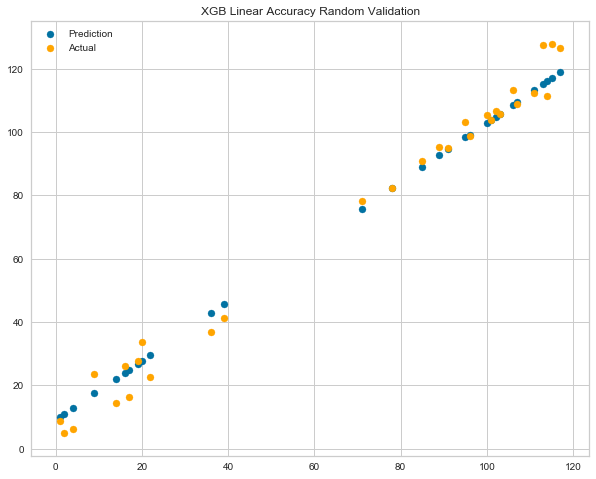

In [268]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_rand, pred, label='Prediction')
plt.scatter(X_test_rand, y_test_rand, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Accuracy Random Validation');

In [269]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_lin_mse_rand_deployed, xgb_lin_mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_lin_mse_rand:.3f}  MAE {xgb_lin_mae_rand:.3f}')
print(f'Deployed  : MSE {xgb_lin_mse_rand_deployed:.3f}  MAE {xgb_lin_mae_rand_deployed:.3f}')
print(f'Validation MAE Error {(abs(xgb_lin_mae_rand - xgb_lin_mae_rand_deployed)) * 100.0 / xgb_lin_mae_rand:.2f}%')

Validation: MSE 27.297  MAE 4.070
Deployed  : MSE 25.044  MAE 4.122
Validation MAE Error 1.30%


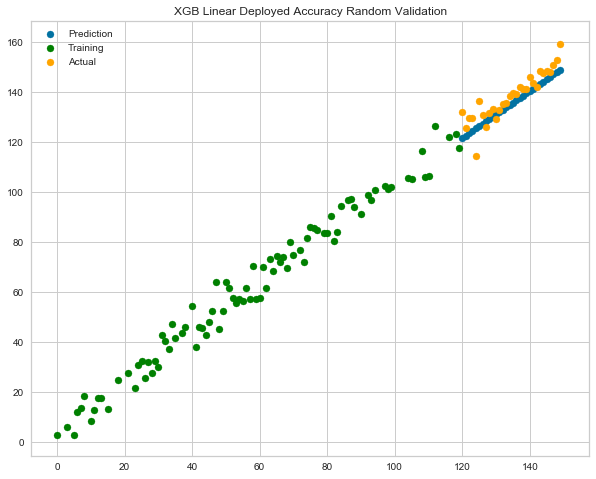

In [270]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Deployed Accuracy Random Validation');

## Last Train - Test Split

In [277]:
pred = boost.predict(X_test_last.reshape(-1,1))
xgb_lin_mse_last, xgb_lin_mae_last = score(pred, y_test_last)
print(f'Random Holdout  : MSE {xgb_lin_mse_rand:.3f}  MAE {xgb_lin_mae_rand:.3f}')
print(f'Last N Model    : MSE {xgb_lin_mse_last:.3f}  MAE {xgb_lin_mae_last:.3f}')

Random Holdout  : MSE 27.297  MAE 4.070
Last N Model    : MSE 24.812  MAE 3.646


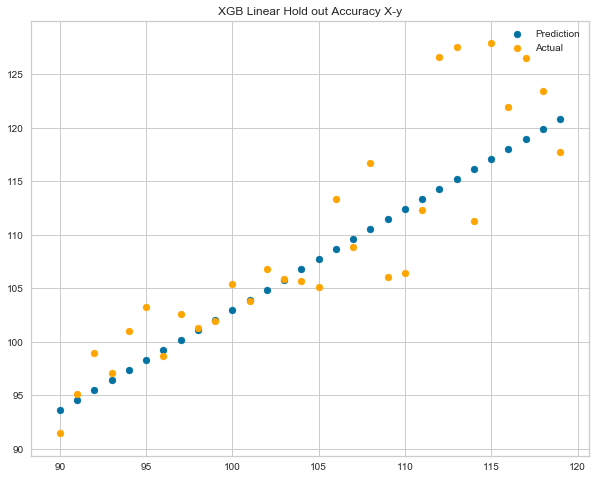

In [278]:
plt.figure(figsize=(10,8))
plt.scatter(X_test_last, pred, label='Prediction')
plt.scatter(X_test_last, y_test_last, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Hold out Accuracy X-y');

In [279]:
pred = boost.predict(X_private.reshape(-1,1))
xgb_lin_mse_last_deployed, xgb_lin_mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {xgb_lin_mse_last:.3f}  MAE {xgb_lin_mae_last:.3f}')
print(f'Deployed  : MSE {xgb_lin_mse_last_deployed:.3f}  MAE {xgb_lin_mae_last_deployed:.3f}')
print(f'Validation MAE Error {(abs(xgb_lin_mae_last - xgb_lin_mae_last_deployed)) * 100.0 / xgb_lin_mae_last:.2f}%')

Validation: MSE 24.812  MAE 3.646
Deployed  : MSE 25.044  MAE 4.122
Validation MAE Error 13.07%


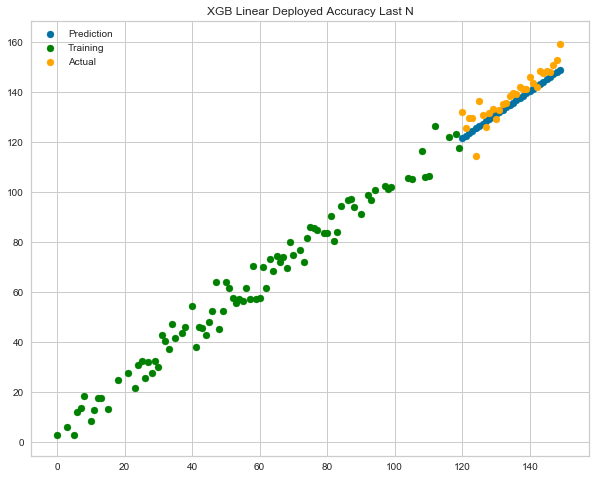

In [280]:
plt.figure(figsize=(10,8))
plt.scatter(X_private, pred, label='Prediction')
plt.scatter(X_train_rand, y_train_rand, color='green', label='Training')
plt.scatter(X_private, y_private, color='orange', label='Actual')
plt.legend()
plt.title('XGB Linear Deployed Accuracy Last N');

## Callout
* XGBoost with linear booster can build a trend
* Bring in last n observations in training
* Caution, XGBoost is using a linear regression at each iteration
    * That reduces to a series of affine functions added together (i.e. it's still linear)
    * It can't handle interactions
    * Can't model exponential trends

# Linear Regression
* XGBoost is heavy handed for this simple forecast
* Let's go for parsimony and use a linear regression

## Random Train - Test Split

In [78]:
lr = LinearRegression()
lr.fit(X_train_rand.reshape(-1,1),  y_train_rand)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [79]:
pred = lr.predict(X_test_rand.reshape(-1,1))
lr_mse_rand, lr_mae_rand = score(pred, y_test_rand)
print(f'MSE {lr_mse_rand:.3f}  MAE {lr_mae_rand:.3f}')

MSE 20.629  MAE 3.710


In [80]:
pred = lr.predict(X_private.reshape(-1,1))
lr_mse_rand_deployed, lr_mae_rand_deployed = scorePrivate(pred)
print(f'Validation: MSE {lr_mse_rand:.3f}  MAE {lr_mae_rand:.3f}')
print(f'Deployed  : MSE {lr_mse_rand_deployed:.3f}  MAE {lr_mae_rand_deployed:.3f}')
print(f'Validation MAE Error {(abs(lr_mae_rand - lr_mae_rand_deployed)) * 100.0 / lr_mae_rand:.2f}%')

Validation: MSE 20.629  MAE 3.710
Deployed  : MSE 17.188  MAE 2.878
Validation MAE Error 22.42%


## Last Train - Test Split

In [81]:
lr = LinearRegression()
lr.fit(X_train_last.reshape(-1,1),  y_train_last)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
pred = lr.predict(X_test_last.reshape(-1,1))
lr_mse_last, lr_mae_last = score(pred, y_test_last)
print(f'MSE {lr_mse_last:.3f}  MAE {lr_mae_last:.3f}')

MSE 25.527  MAE 4.119


In [83]:
pred = lr.predict(X_private.reshape(-1,1))
lr_mse_last_deployed, lr_mae_last_deployed = scorePrivate(pred)
print(f'Validation: MSE {lr_mse_last:.3f}  MAE {lr_mae_last:.3f}')
print(f'Deployed  : MSE {lr_mse_last_deployed:.3f}  MAE {lr_mae_last_deployed:.3f}')
print(f'Validation MAE Error {(abs(lr_mae_last - lr_mae_last_deployed)) * 100.0 / lr_mae_last:.2f}%')

Validation: MSE 25.527  MAE 4.119
Deployed  : MSE 27.115  MAE 4.266
Validation MAE Error 3.58%


## Callout
* We got a better MAE with random (2.878) compared to last n (4.119)
* Our validation tracked to deployed much better with last n (3.58%) compared to (22.42%)
* Last n is a better validation strategy!

## Wait
* Linear regression assumes independent and identically distributed data
* We don't have that here, these points have strong correlation with eachother
* Despite the violation we can use Linear Regression if we assume:
    * The series is linear with respect to the dependent variable
    * No perfectly correlated independent variables
    * No constant independent variables
    * The expected value of errors is zero & our variance is independent of time
    * Errors are not correlated with independent variables

# Hodrick Prescott Filter

In [50]:
cycle, trend = hpfilter(y_train_last, lamb=1600)

## Trend

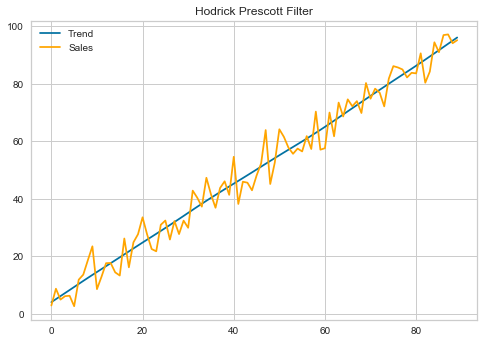

In [51]:
plt.plot(trend, label='Trend')
plt.plot(y_train_last, color='orange', label='Sales')
plt.legend()
plt.title('Hodrick Prescott Filter - Trend');

## Cyclical

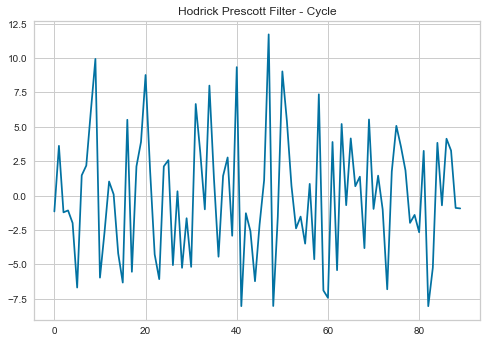

In [53]:
plt.plot(cycle)
plt.title('Hodrick Prescott Filter - Cycle');

## Reconstruction

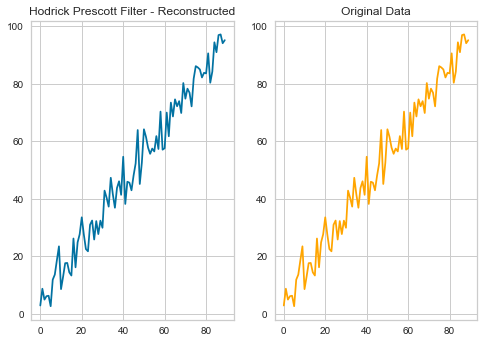

In [59]:
plt.subplot(1, 2, 1)
plt.plot(trend + cycle)
plt.title('Hodrick Prescott Filter - Reconstructed')

plt.subplot(1, 2, 2)
plt.plot(trend + cycle, color='orange')
plt.title('Original Data')

plt.show();

## Prediction
* Can't use Hodrick Prescott for predicting, it just decomposition for a series

# Other Patterns

## Data

In [87]:
!kaggle datasets download -d rakannimer/air-passengers -p ./air-passengers

  0%|                                                 | 0.00/764 [00:00<?, ?B/s]
100%|███████████████████████████████████████████| 764/764 [00:00<00:00, 471kB/s]


In [96]:
!unzip -o ./air-passengers/air-passengers.zip -d ./air-passengers

Archive:  ./air-passengers/air-passengers.zip
  inflating: ./air-passengers/AirPassengers.csv  


In [104]:
ap = pd.read_csv('./air-passengers/AirPassengers.csv')

In [107]:
ap.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


## Index & Columns

In [116]:
ap['Month'] = pd.DatetimeIndex(ap.Month)
ap = ap.rename(columns={'#Passengers': 'Passengers'})
ap.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## Plot Data

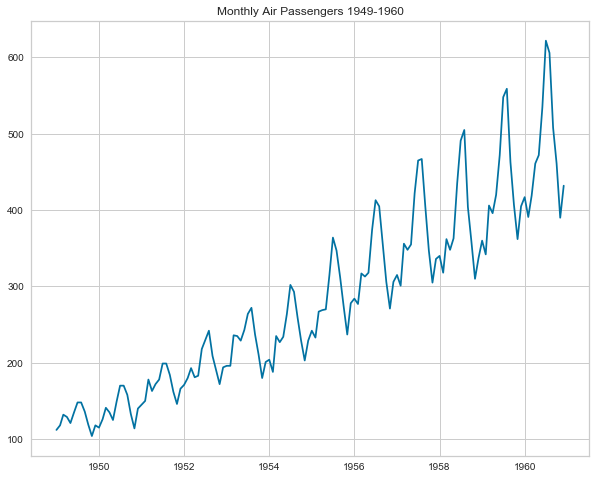

In [119]:
plt.figure(figsize=(10,8))
plt.plot(ap.Month, ap.Passengers)
plt.title('Monthly Air Passengers 1949-1960');

## Observations
* Assume we want to predict on the tail i.e. 1961+
* We have a trend, looks slightly exponential
* There's a strong seasonality component in the data
* The variance is increasing over time
* Linear regression is going to have problems
    * For one - it is assumed to have independent observations
* Enter models equipped to deal with these issues - time series models

# Time Series Models
* Forecasting & Validation Strategy 
    * Single Step
    * Multi Step
* Library Support
    * Pandas
    * Statsmodels
    * tslearn
    * tsfresh
    * tspreprocess
* Classical Models
    * ETS Decomposition
    * Moving Average
    * Holt Winters
* ARIMA (Pyramid)
* VAR Models
* State Space Models
* Prophet
* Recurrent Neural Networks
* AWS Forecast